In [1]:
from Phi import *
from utils.ToyModels import *
import torch
from torch import nn, tensor, Tensor, optim
import torch.nn.functional as F
from torchdiffeq import odeint, odeint_adjoint
import matplotlib.pyplot as plt
from matplotlib import animation
import os
import re

In [2]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

In [160]:
p2gaussians = "./gaussians"

regex = r"\d+"
all_itr = list(map(int,set([re.findall(regex, i)[0] for i in os.listdir(p2gaussians)])))
all_itr.sort()
checkpoint_name = "gaussians"+str(all_itr[-1])+".pth"
checkpoint = torch.load(os.path.join(p2gaussians, checkpoint_name), map_location=device)
print(checkpoint['epoch'])

12000


In [338]:
p2moons = "./moons"

regex = r"\d+"
all_itr = list(map(int,set([re.findall(regex, i)[0] for i in os.listdir(p2moons)])))
all_itr.sort()
checkpoint_name = "moons"+str(all_itr[-1])+".pth"
checkpoint = torch.load(os.path.join(p2moons, checkpoint_name), map_location=device)
print(checkpoint['epoch'])

54200


In [4]:
class OdeFunc(nn.Module):
    def __init__(self, d: int, m:int, nTh: int):
        super(OdeFunc, self).__init__()
        self.d = d
        self.m = m
        self.nTh = nTh
        self.net = Phi(self.nTh, self.m, self.d).to(device)
    
    def forward(self, t, x):
        x = x[:, :self.d]
        # z = F.pad(x,[0,1,0,0],  value=t)
        z = torch.cat((x, t*torch.ones(x.shape[0],1).to(device)), 1)
        gradPhi, trH = self.net.trHess(z)
        dx = - gradPhi[:,:self.d]
        dl = - trH.unsqueeze(1)
        dv = 0.5 * torch.sum(torch.pow(dx, 2), 1, keepdim=True)
        dr = torch.abs(-gradPhi[:,-1].unsqueeze(1) +  dv)
        return torch.cat((dx, dl, dv, dr), 1)


def get_batch(n_smple):
    x, _ = generate_moon_data(n_samples=n_smple, noise=2e-1)
    return x


def compute_loss(x: torch.Tensor):
    d = x.shape[1] - 3
    C = 1/2 * torch.sum(torch.pow(x[:, :d], 2), dim=1) - x[:, -3] + torch.log(torch.tensor([2]) * torch.pi).to(device)
    L = x[:,-2].mean()
    R = x[:,-1].mean()
    return C.mean() + L + R

In [8]:
d = 2
m = 64
OTFlow = OdeFunc(d,m, 2).to(device)
optimizer = optim.Adam(OTFlow.parameters(), lr=1e-3)
t0 = 0
t1 = 1

In [347]:

p2moons = "./moons"

regex = r"\d+"
all_itr = list(map(int,set([re.findall(regex, i)[0] for i in os.listdir(p2moons)])))
all_itr.sort()
checkpoint_name = "moons"+str(all_itr[-1])+".pth"
checkpoint = torch.load(os.path.join(p2moons, checkpoint_name), map_location=device)
print(checkpoint['epoch'])

59200


In [348]:
# checkpoint = torch.load("./t6000.pt", map_location=device)
checkpoint["epoch"]
OTFlow.load_state_dict(checkpoint["model_state_dict"])
OTFlow.eval()
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])


In [349]:
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[1, 0.0], [0.0, 1]]).to(device)
)

z0 = p_z0.sample(torch.tensor([10000]))
z0 = F.pad(z0, [0,3,0,0], value=0)
# t_reverse = torch.tensor([t1,t0], dtype=torch.float32).to(device)
t_reverse = torch.linspace(t1,t0, 1000)


(-4.0, 4.0)

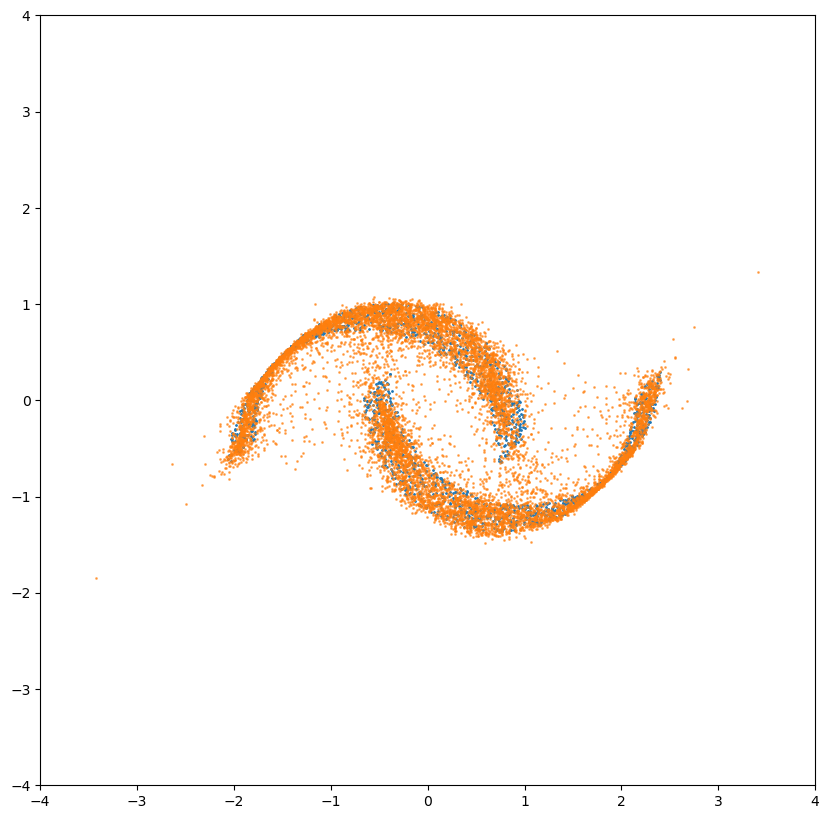

In [350]:
with torch.no_grad():
    z1_vis = odeint(OTFlow, z0, t_reverse,
           rtol=1e-5,
           atol=1e-5)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(*generate_moon_data(n_samples=2000,noise=2e-1)[0].T,s=1)
ax.scatter(*z1_vis[-1][:,:2].detach().cpu().T, s=1, alpha=0.6)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)


In [287]:
ani = animation.FuncAnimation(fig, animate, frames=len(z1_vis) + 120)
FFwriter = animation.FFMpegWriter(fps=60)
ani.save('animation.mp4', writer = FFwriter)


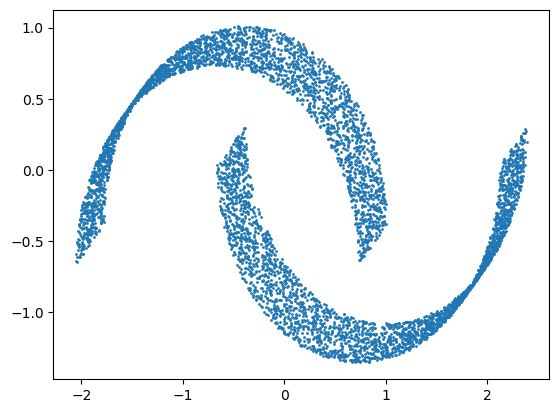

In [229]:
X,_ = generate_moon_data(n_samples=6000, noise=2e-1)
plt.scatter(*X.T,s=1)

In [260]:
def animate(i):
    ax.cla()
    if i < 60:
        ax.scatter(*X.T, s=1.)
        ax.scatter(*z1_vis[0][:,:2].detach().cpu().T, s=1., alpha=0.8)
    elif 60 <= i < 1060:
        ax.scatter(*X.T, s=1.)
        ax.scatter(*z1_vis[i-60][:,:2].detach().cpu().T, s=1., alpha=0.8)
    else:
        ax.scatter(*X.T, s=1.)
        ax.scatter(*z1_vis[-1][:,:2].detach().cpu().T, s=1., alpha=0.8)
        
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)

In [283]:
ani = animation.FuncAnimation(fig, animate, frames=len(z1_vis) + 120)
writer = animation.PillowWriter(fps=60,
                                # metadata=dict(artist='Me'),
                               )
ani.save('moons6x6.gif', writer = writer) 

(-4.0, 4.0)

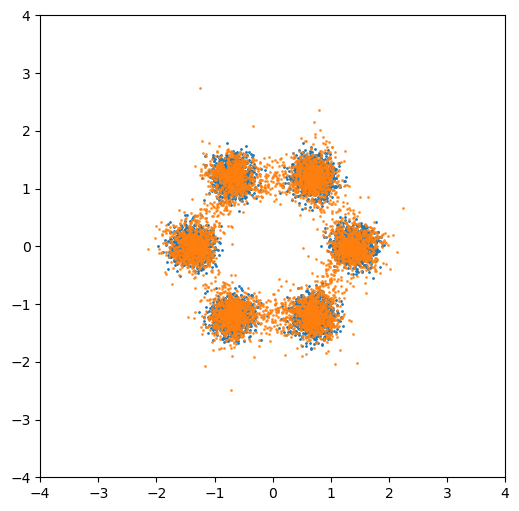

In [103]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(*X.T, s=1.)
ax.scatter(*z1_vis[-1][:,:2].detach().cpu().T,s=1., alpha=0.8)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)

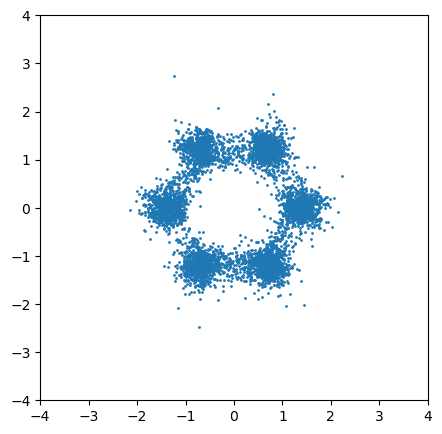

In [87]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(*z1_vis[-1][:,:2].detach().cpu().T, s=1)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)
plt.show()

In [299]:
p2spheres = "./spheres"

regex = r"\d+"
all_itr = list(map(int,set([re.findall(regex, i)[0] for i in os.listdir(p2spheres)])))
all_itr.sort()
checkpoint_name = "spheres"+str(all_itr[-1])+".pth"
checkpoint = torch.load(os.path.join(p2spheres, checkpoint_name), map_location=device)
OTFlow.load_state_dict(checkpoint['model_state_dict'])
OTFlow.eval()
print(checkpoint['epoch'])

15400


In [300]:
t0=0
t1=1
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[1, 0.0], [0.0, 1]]).to(device)
)

z0 = p_z0.sample(torch.tensor([10000]))
z0 = F.pad(z0, [0,3,0,0], value=0)
# t_reverse = torch.tensor([t1,t0], dtype=torch.float32).to(device)
t_reverse = torch.linspace(t1,t0, 1000)

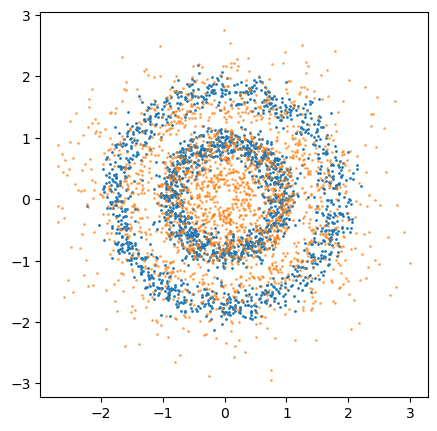

In [301]:
t = torch.linspace(t0,t1,1000)

x, _ = generate_spheres_data(2000, noise=8e-2)
x = F.pad(x, [0,3,0,0], value=0)

with torch.no_grad():
    z1_vis = odeint(OTFlow, x, t,
           rtol=1e-5,
           atol=1e-5)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(*generate_spheres_data(n_samples=2000,noise=8e-2)[0].T,s=1)
ax.scatter(*z1_vis[-1][:,:2].detach().cpu().T, s=1, alpha=0.6)



(-4.0, 4.0)

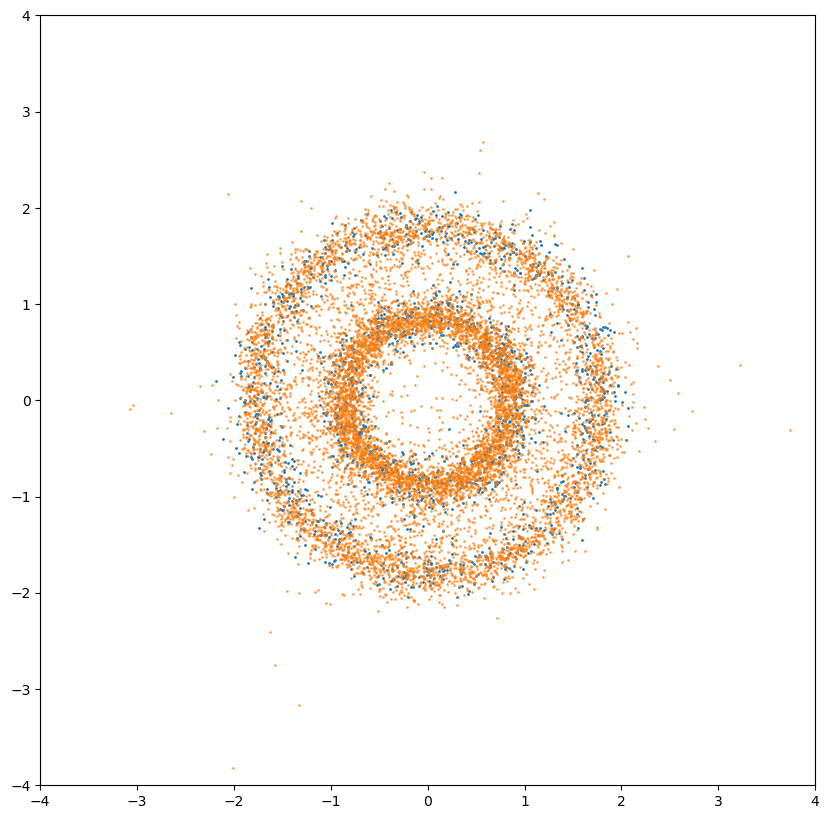

In [302]:
X,_ = generate_spheres_data(n_samples=2000,noise=8e-2)
with torch.no_grad():
    z1_vis = odeint(OTFlow, z0, t_reverse,
           rtol=1e-5,
           atol=1e-5)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.scatter(*generate_spheres_data(n_samples=2000,noise=8e-2)[0].T,s=1)
ax.scatter(*X.T,s=1)
ax.scatter(*z1_vis[-1][:,:2].detach().cpu().T, s=1, alpha=0.6)
# ax.scatter(*z1_vis[0][:,:2].detach().cpu().T, s=1, alpha=0.6)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)

In [303]:
ani = animation.FuncAnimation(fig, animate, frames=len(z1_vis) + 120)
FFwriter = animation.FFMpegWriter(fps=60)
ani.save('spheres.mp4', writer = FFwriter)
